In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import re

import nltk
from nltk.tokenize import WhitespaceTokenizer, WordPunctTokenizer, TreebankWordTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss, jaccard_score
# from transformers import DistilBertModel,DistilBertConfig, BertConfig, DistilBertTokenizer, AutoModel, AutoTokenizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.multioutput import MultiOutputClassifier

# from xgboost import XGBClassifier

import seaborn as sns

from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, model_from_json
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SpatialDropout1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers import Input
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

# !pip install arff
# !pip install scikit-multilearn
# from skmultilearn.problem_transform import BinaryRelevance
# from skmultilearn.ext import Keras


In [2]:
def load_files(file_path):
    all_files = glob.glob(os.path.join(path, "*.csv"))

    li = []

    for i in range(len(all_files)):
        df = pd.read_csv(all_files[i], index_col=None, header=0, error_bad_lines=False)
        li.append(df)
    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

In [3]:
# #files for google colab
# from google.colab import files
# uploaded = files.upload()

In [4]:
dataframe = pd.read_csv('master_clauses.csv')
# dataframe.head()
# dataframe.columns
dataframe.head()
dataframe.rename(columns = {'Filename':'Clause'}, inplace = True)
dataframe.head()
dataframe.drop(dataframe.index, inplace=True)
for i in range(2,43,1):
    dataframe[dataframe.columns[i-1]] = pd.to_numeric(dataframe[dataframe.columns[i-1]])
    dataframe.drop(dataframe.columns[i],axis=1, inplace = True)   
dataframe.head()
len(dataframe.columns)

42

In [5]:
# files = os.listdir('CUAD_v1/label_group_xlsx')
files = os.listdir('.')
for file in files:
    if (not(file.startswith("Label Report"))):
      continue
    file_path = file
    df_lb_group = pd.read_excel(file_path)
    print(file)
    if((file == "Label Report - Dates (Group 1).xlsx") or (file == "Label Report - Parties.xlsx")):
        print(file)
        df_lb_group.drop([col for col in df_lb_group.columns if 'Answer' in col],axis=1,inplace=True)
#         df = df[df.columns.drop(list(df.filter(regex='Answer')))]
#         df_lb_group.drop([df_lb_group.columns[2], df_lb_group.columns[4], df_lb_group.columns[6],
#                            df_lb_group.columns[8], df_lb_group.columns[10]],axis=1, inplace = True)
#     elif(file == "Label Report - Parties.xlsx"):
        
    df_lb_group.drop(df_lb_group.columns[0],axis=1, inplace = True)
    for column in df_lb_group.columns:
        lista = df_lb_group[column]
        lista.dropna(inplace = True)
        #     print(lista)
        for clauses in lista:
            clauses = re.sub(r'\(Page \d+\)', "", clauses)  
#             print(clauses)
            clauses_list = clauses.split('\n\n')
            for clause in clauses_list:
                num = (dataframe['Clause'] == clause).any()
                if num == 0:
                    new_row = [0] * 42
                    new_row[0] = clause
                    dataframe = dataframe.append(pd.Series(new_row, index=dataframe.columns[:len(new_row)]), ignore_index=True)
                dataframe[column][dataframe['Clause'] == clause] = 1

Label Report - Anti-assignment, CIC (Group 3).xlsx


<ipython-input-5-25a1684ce961>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column][dataframe['Clause'] == clause] = 1


Label Report - Audit Rights.xlsx
Label Report - Covenant not to Sue_ Release of Claims.xlsx
Label Report - Dates (Group 1).xlsx
Label Report - Dates (Group 1).xlsx
Label Report - Document Name.xlsx
Label Report - Governing Law.xlsx
Label Report - Insurance.xlsx
Label Report - IP Ownership Assignment.xlsx
Label Report - Joint IP Ownership.xlsx
Label Report - Licenses (Group 4).xlsx
Label Report - Liquidated Damages.xlsx
Label Report - Minimum Commitment.xlsx
Label Report - Most Favored Nation.xlsx
Label Report - No-Solicit of Employees.xlsx
Label Report - Non-Compete, Exclusivity, No-Solicit of Customers (Group 2).xlsx
Label Report - Non-Disparagement.xlsx
Label Report - Parties.xlsx
Label Report - Parties.xlsx
Label Report - Post-Termination Services.xlsx
Label Report - Price Restrictions.xlsx
Label Report - Revenue-Profit Sharing.xlsx
Label Report - ROFR-ROFO-ROFN.xlsx
Label Report - Source Code Escrow.xlsx
Label Report - Termination for Convenience.xlsx
Label Report - Third Party Ben

In [6]:
# df_lb_group.head()
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12203 entries, 0 to 12202
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Clause                              12203 non-null  object
 1   Document Name                       12203 non-null  int64 
 2   Parties                             12203 non-null  int64 
 3   Agreement Date                      12203 non-null  int64 
 4   Effective Date                      12203 non-null  int64 
 5   Expiration Date                     12203 non-null  int64 
 6   Renewal Term                        12203 non-null  int64 
 7   Notice Period To Terminate Renewal  12203 non-null  int64 
 8   Governing Law                       12203 non-null  int64 
 9   Most Favored Nation                 12203 non-null  int64 
 10  Competitive Restriction Exception   12203 non-null  int64 
 11  Non-Compete                         12203 non-null  in

In [7]:
dataframe

,Clause,Document Name,Parties,Agreement Date,Effective Date,Expiration Date,Renewal Term,Notice Period To Terminate Renewal,Governing Law,Most Favored Nation,...,Source Code Escrow,Post-Termination Services,Audit Rights,Uncapped Liability,Cap On Liability,Liquidated Damages,Warranty Duration,Insurance,Covenant Not To Sue,Third Party Beneficiary
0,"For purposes of the preceding sentence, and wi...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The term of this Agreement shall be effective ...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"For purposes of this Agreement, ""Change in Con...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Neither party shall voluntarily or by operatio...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Nothwithstanding the foregoing, this Agreement...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12198,Licensee shall accept or reject the Licensed P...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
12199,For twelve (12) months after delivery of the M...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
12200,For twelve (12) months after delivery of any L...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
12201,If Licensee or any Redistributor or Customer d...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [8]:
labels = dataframe.drop(['Clause'],axis=1)
labels.head()

,Document Name,Parties,Agreement Date,Effective Date,Expiration Date,Renewal Term,Notice Period To Terminate Renewal,Governing Law,Most Favored Nation,Competitive Restriction Exception,...,Source Code Escrow,Post-Termination Services,Audit Rights,Uncapped Liability,Cap On Liability,Liquidated Damages,Warranty Duration,Insurance,Covenant Not To Sue,Third Party Beneficiary
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

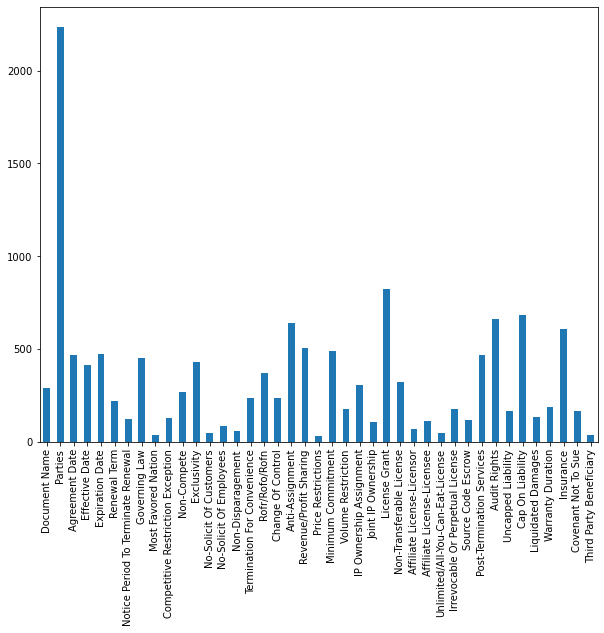

In [9]:
#total clause counts for different labels
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

labels.sum(axis=0).plot.bar()

C:\Users\Nikolina\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


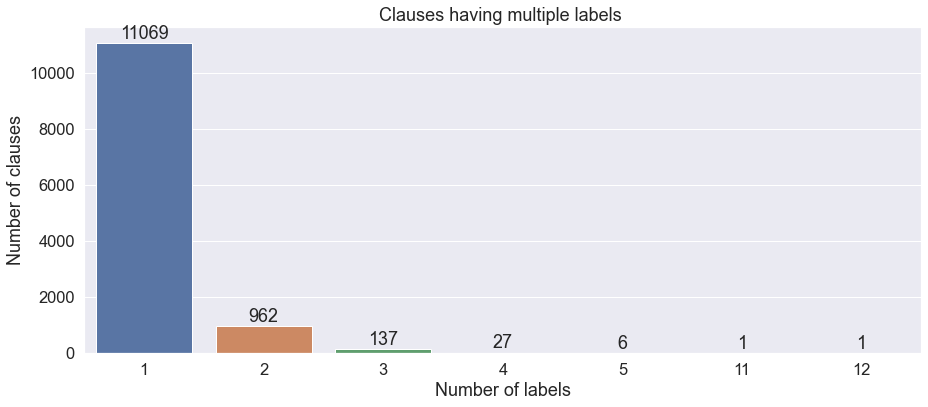

In [10]:
# Counting the number of clauses having multiple labels

rowSums = dataframe.iloc[:,1:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
sns.set(font_scale =1.5)
plt.figure(figsize=(15,6))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Clauses having multiple labels ")
plt.ylabel('Number of clauses', fontsize=18) 
plt.xlabel('Number of labels', fontsize=18)
#adding the text labels
rects = ax.patches
labels_ = multiLabel_counts.values
for rect, label in zip(rects, labels_):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [11]:
#data pre-processing
def preprocess(sen):
    
    snowball = SnowballStemmer(language='english')


    # # Remove all the special characters
    document = re.sub(r'\W', ' ', str(sen))

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)

    # Converting to Lowercase
   # document = document.lower()
    
    

    # Steamming
    document = document.split()

    document = [snowball.stem(word) for word in document]
    
    #Remove stop words
    #document = [word for word in document if not word in stopwords.words()]
    
    document = ' '.join(document)
    return document

In [12]:
sentences = list(dataframe["Clause"])
docs = []
for sen in sentences:
    docs.append(preprocess(sen))
docs

['for purpos of the preced sentenc and without limit it general ani merger consolid or reorgan involv license regardless of whether license is surviv or disappear entiti will be deem to be transfer of right oblig or perform under this agreement for which licensor prior written consent is requir',
 'the term of this agreement shall be effect as of the date first state abov and shall continu for term of three 3 year unless termin earlier in accord with the provis of this agreement the term provid howev that primecal may elect to termin this agreement upon thirti 30 day written notic at ani time from and after the time that collect rsl communic ltd and or it affili hold less than fifti percent 50 of the vote control of deltathre outstand share',
 'for purpos of this agreement chang in control mean merger or consolid of the parti with or ani sale of all or substanti all of the asset of such parti to ani other person corpor or entiti unless as result of such merger consolid or sale of asset

In [13]:
#split data into train and test
X = docs
y = labels.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [14]:
def glove_embedding_matrix(file_path, vocab_size, tokenizer):
    embeddings_dictionary = dict()

    glove_file = open(file_path, encoding="utf8")

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
    glove_file.close()

    embedding_matrix = np.zeros((vocab_size, 100))
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    return embedding_matrix

In [15]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
def create_model(vocab_size, embedding_matrix, shape):
  model = Sequential()
  model.add(Embedding(vocab_size, 100,  weights=[embedding_matrix], input_length=shape))
  model.add(SpatialDropout1D(0.2))
  model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(41, activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])
  return model

def grid_search_rnn(X,Y, vocab_size, embedding_matrix):

  # create model
  c_model = KerasClassifier(build_fn=lambda: create_model(vocab_size, embedding_matrix, X.shape[1]))
  dfx = pd.DataFrame(X)
  # define the grid search parameters
  batch_sizes = [32, 64]
  epochs = [10, 20, 30]
  learning_rates = [0.01, 0.1]
  x_train, x_val, y_train, y_val = train_test_split(dfx, Y, train_size = 0.8,random_state = 2021)
  split_index = [-1 if row in x_train.index else 0 for row in dfx.index]
  print(split_index) 
  pds = PredefinedSplit(test_fold = split_index)
  parameters = {'batch_size': batch_sizes, 'epochs': epochs}
  print(parameters)
  grid = GridSearchCV(estimator=c_model, param_grid=parameters, cv=pds)
  grid_result = grid.fit(X, Y)

  print(grid_result.best_score_)
  print(grid_result.best_params_)

  return grid_result.best_estimator_ 

In [17]:
#RNN
fp = './glove.6B.100d.txt'

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_tr = tokenizer.texts_to_sequences(X_train)
X_te = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200
embedding_matrix = glove_embedding_matrix(fp, vocab_size, tokenizer)


In [18]:
max_clause_length = 500
X_train = pad_sequences(X_tr, maxlen=max_clause_length)
X_test = pad_sequences(X_te, maxlen=max_clause_length)

In [26]:
# truncate and pad input sequences
# max_clause_length = 500
# X_train = pad_sequences(X_tr, maxlen=max_clause_length)
# X_test = pad_sequences(X_te, maxlen=max_clause_length)
lstm_par = grid_search_rnn(X_train, y_train, vocab_size, embedding_matrix)

[0, 0, -1, -1, -1, -1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, -1, -1, -1, 0, -1, 0, -1, -1, -1, 0, -1, -1, -1, 0, -1, -1, 0, -1, -1, 0, 0, 0, -1, -1, 0, -1, 0, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, 0, -1, 0, -1, -1, -1, 0, -1, -1, -1, -1, -1, 0, -1, 0, -1, -1, 0, -1, -1, -1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, 0, -1, -1, 0, -1, -1, -1, -1, -1, -1, 0, -1, 0, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, 0, 0, -1, -1, -1, 0, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, 0, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, 0, 0, -1, -1, -1, 0, -1, 0, -1, -1, -1, -1, 0, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -

Epoch 1/10
245/245 [==============================] - 255s 1s/step - loss: 0.0931 - accuracy: 0.3360 - f1_m: 0.2627 - precision_m: 0.7744 - recall_m: 0.1614
Epoch 2/10
245/245 [==============================] - 249s 1s/step - loss: 0.0683 - accuracy: 0.5103 - f1_m: 0.4487 - precision_m: 0.9190 - recall_m: 0.3028
Epoch 3/10
245/245 [==============================] - 251s 1s/step - loss: 0.0544 - accuracy: 0.6108 - f1_m: 0.5769 - precision_m: 0.9116 - recall_m: 0.4277
Epoch 4/10
245/245 [==============================] - 250s 1s/step - loss: 0.0464 - accuracy: 0.6710 - f1_m: 0.6408 - precision_m: 0.9163 - recall_m: 0.4979
Epoch 5/10
245/245 [==============================] - 260s 1s/step - loss: 0.0408 - accuracy: 0.7183 - f1_m: 0.6788 - precision_m: 0.9080 - recall_m: 0.5455
Epoch 6/10
245/245 [==============================] - 262s 1s/step - loss: 0.0371 - accuracy: 0.7457 - f1_m: 0.7139 - precision_m: 0.9168 - recall_m: 0.5884
Epoch 7/10
245/245 [==============================] - 265s

123/123 [==============================] - 244s 2s/step - loss: 0.0354 - accuracy: 0.7636 - f1_m: 0.7245 - precision_m: 0.9129 - recall_m: 0.6024
Epoch 10/30
123/123 [==============================] - 243s 2s/step - loss: 0.0324 - accuracy: 0.7826 - f1_m: 0.7562 - precision_m: 0.9246 - recall_m: 0.6419
Epoch 11/30
123/123 [==============================] - 243s 2s/step - loss: 0.0294 - accuracy: 0.8020 - f1_m: 0.7780 - precision_m: 0.9332 - recall_m: 0.6691
Epoch 12/30
123/123 [==============================] - 243s 2s/step - loss: 0.0281 - accuracy: 0.8157 - f1_m: 0.7898 - precision_m: 0.9331 - recall_m: 0.6872
Epoch 13/30
123/123 [==============================] - 242s 2s/step - loss: 0.0257 - accuracy: 0.8292 - f1_m: 0.8042 - precision_m: 0.9399 - recall_m: 0.7044
Epoch 14/30
123/123 [==============================] - 243s 2s/step - loss: 0.0244 - accuracy: 0.8416 - f1_m: 0.8092 - precision_m: 0.9337 - recall_m: 0.7157
Epoch 15/30
123/123 [==============================] - 244s 2s/s

306/306 [==============================] - 337s 1s/step - loss: 0.0097 - accuracy: 0.9311 - f1_m: 0.9151 - precision_m: 0.9809 - recall_m: 0.8599
0.781361997127533
{'batch_size': 32, 'epochs': 30}


In [29]:
#{'batch_size': 32, 'epochs': 30}
model = Sequential()
model.add(Embedding(vocab_size, 100,  weights=[embedding_matrix], input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(41, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

epochs = 30
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/30
275/275 [==============================] - 321s 1s/step - loss: 0.0887 - accuracy: 0.3679 - f1_m: 0.2918 - precision_m: 0.7955 - recall_m: 0.1828 - val_loss: 0.0706 - val_accuracy: 0.4821 - val_f1_m: 0.3887 - val_precision_m: 0.9086 - val_recall_m: 0.2505
Epoch 2/30
275/275 [==============================] - 324s 1s/step - loss: 0.0626 - accuracy: 0.5524 - f1_m: 0.4940 - precision_m: 0.9082 - recall_m: 0.3459 - val_loss: 0.0578 - val_accuracy: 0.5824 - val_f1_m: 0.5598 - val_precision_m: 0.8616 - val_recall_m: 0.4184
Epoch 3/30
275/275 [==============================] - 325s 1s/step - loss: 0.0501 - accuracy: 0.6431 - f1_m: 0.6139 - precision_m: 0.9138 - recall_m: 0.4679 - val_loss: 0.0488 - val_accuracy: 0.6622 - val_f1_m: 0.6212 - val_precision_m: 0.9141 - val_recall_m: 0.4738
Epoch 4/30
275/275 [==============================] - 326s 1s/step - loss: 0.0432 - accuracy: 0.6973 - f1_m: 0.6628 - precision_m: 0.9108 - recall_m: 0.5252 - val_loss: 0.0455 - val_accuracy: 0.6940 

In [30]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 77.22%


In [31]:
from sklearn.metrics import f1_score
y_pred = model.predict(X_test)
f1_score(y_test, np.round(y_pred), average='micro')
# scores

0.7662709783053623

In [30]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

# counter = Counter(y_train)
# print('Before', counter)
ros = RandomOverSampler()
x_train_ros, y_train_ros = ros.fit_sample(X_train, y_train)

ValueError: Imbalanced-learn currently supports binary, multiclass and binarized encoded multiclasss targets. Multilabel and multioutput targets are not supported.

In [28]:
len(X_train)

9762

In [1]:
import imblearn as imb
imb. __version__

ImportError: cannot import name 'six' from 'sklearn.externals' (C:\Users\Nikolina\anaconda3\lib\site-packages\sklearn\externals\__init__.py)